# <center> AB Testing

### <center> Test design and proportion tests

In [1]:
import math
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_effectsize, proportions_ztest, proportions_chisquare
from statsmodels.stats.power import zt_ind_solve_power as solve_power

### The scenario...

Your company wants to test a new website layout to see if it can increase the chance of a purchase with each visitor. The current layout is estimated to generate a sale 30% of the time. You are tasked with testing whether or not a new design increases the rate of a sale occuring. You need to run a test that will allow you to statistically detect an increase in sale probability by 10% with a confidence level of 95%.

### <center> Hypotheses

<center> A = Old layout purchase chance<br>
<center> B = New layout purchase chance

### Null Hypothesis (H<sub>0</sub>): B = A

### Alternative Hypothesis (H<sub>a</sub>): B > A

### <center> Determine sample size needed

In [2]:
def sample_size_needed(p0,p_diff,alpha,power,alternative):
    effect_size = proportion_effectsize(p0+p_diff,p0)
    n = solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative=alternative)
    return math.ceil(n)

In [3]:
sample_size_needed(p0=0.30, p_diff=0.10, alpha=0.05, power=0.8, alternative='larger')

280

## <center> Two Sample Proportion Test

In [4]:
n = 280

In [5]:
np.random.seed(47)
A = np.random.choice([0,1],n, )
B = np.random.choice([0,0,0,0,1,1,1,1,1,1],n)

In [6]:
df = pd.DataFrame()
df['Yes'] = [A.mean()*len(A), B.mean()*len(B)]
df['No'] = [(1-A.mean())*len(A), (1-B.mean())*len(B)]
df['Group'] = ['A', 'B']
df = df.set_index('Group')
df

,Yes,No
Group,,
A,134.0,146.0
B,166.0,114.0


<center><img src='two_proportion_z_test.png.'>

<center><img src='p_star.png'>

In [7]:
def ztest_proportion_two_samples(x1, n1, x2, n2):
    p1 = x1/n1
    p2 = x2/n2    
    p_star = (n1*p1 + n2*p2)/(n1+n2)
    
    se = np.sqrt(p_star*(1-p_star)*(1/n1+1/n2))
    
    z = (p1-p2)/se
    
    p = (1-stats.norm.cdf(abs(z)))*2
    return z, p

z,p = ztest_proportion_two_samples(df['Yes']['A'], n, df['Yes']['B'], n)
print('z-stat:',z)
print('p-value:',p)

z-stat: -2.7114193463562346
p-value: 0.006699583757154404


# <center>Chi Squared Distribution

<center>Found by squaring a standard normal distribution (when degrees of freedom is 1)

Text(0.5, 1.0, 'Standard Normal Distribution')

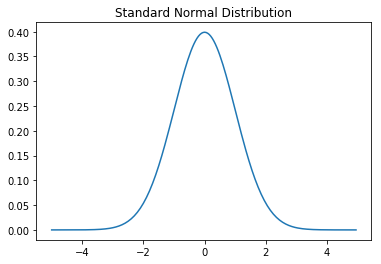

In [8]:
x = np.arange(-5,5,0.05)
plt.plot(x,stats.norm.pdf(x)); plt.title('Standard Normal Distribution')

Text(0.5, 1.0, 'Chi Squared Distribution (k=1)')

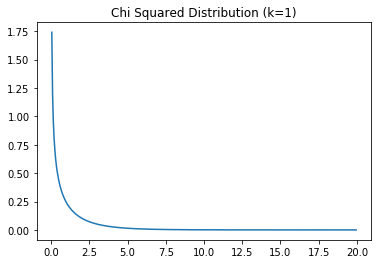

In [10]:
x = np.arange(0,20,0.05)
plt.plot(x,stats.chi2.pdf(x,1)); plt.title('Chi Squared Distribution (k=1)')

Chi Squared at other values of k or degrees of freedom

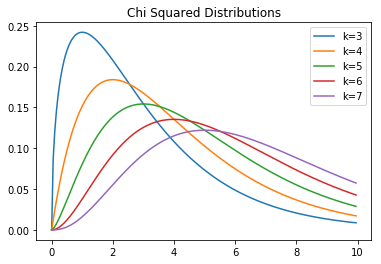

In [11]:
x = np.arange(0,10,0.05)
for k in range(3,8):
    plt.plot(x,stats.chi2.pdf(x,k))
plt.title('Chi Squared Distributions')
plt.legend(['k=' + str(x) for x in range(3,8)])

### <center>Properties of Chi Squared Distributions

<center> μ = k

<center> σ² = 2k

<center> mode = k - 2 

### <center> Degrees of Freedom for Chi Squared

### <center>k = (c-1)\*(r-1)
<br><br>
<center> Where `c` is the number of columns and `r` is the number of rows. <br><br>
<center> Or, (number of possible outcomes - 1) * (number of groups - 1)

### <center> Chi Squared Formula

<center><img src='chi-squared-equation.png'>

In [12]:
df

,Yes,No
Group,,
A,134.0,146.0
B,166.0,114.0


In [13]:
def chi_squared_test_two_sample(x1, n1, x2, n2):
    x1_0 = n1-x1
    x2_0 = n2-x2
    expected_1 = (x1+x2)/(n1+n2)
    expected_0 = (x1_0+x2_0)/(n1+n2)
    
    chi = (x1-expected_1*n1)**2/(expected_1*n1) + (x2-expected_1*n2)**2/(expected_1*n2) + (x1_0-expected_0*n1)**2/(expected_0*n1) + (x2_0-expected_0*n2)**2/(expected_0*n2)
    p = 1-stats.chi2.cdf(chi,1)
    return chi,p
chi,p = chi_squared_test_two_sample(df['Yes']['A'], n, df['Yes']['B'], n)
print('z-stat:',chi)
print('p-value:',p)

z-stat: 7.351794871794873
p-value: 0.006699583757154404


### <center> With two sample groups, a Z Proportions Test and a Chi Squared Test will give the same results

And now the quicker way to do both...

In [14]:
z,p = proportions_ztest(count=df['Yes'],nobs=n)
z,p

(-2.7114193463562346, 0.00669958375715444)

In [15]:
chi,p,table = proportions_chisquare(count=df['Yes'],nobs=n)
chi,p

(7.351794871794873, 0.0066995837571544375)

### <center> AB...N Testing

### <center> What if we want to test more than two options?

### Null Hypothesis (H<sub>0</sub>): C = B = A

### Alternative Hypothesis (H<sub>a</sub>): At least one of A,B,C is different

### <center> The data

In [16]:
np.random.seed(47)
A = np.random.choice([0,1],n)
B = np.random.choice([0,0,0,0,1,1,1,1,1],n)
C = np.random.choice([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],n)
df = pd.DataFrame()
df['Yes'] = [A.mean()*len(A), B.mean()*len(B), C.mean()*len(C)]
df['No'] = [(1-A.mean())*len(A), (1-B.mean())*len(B), (1-C.mean())*len(C)]
df['Group'] = ['A', 'B', 'C']
df = df.set_index('Group')
df

,Yes,No
Group,,
A,134.0,146.0
B,149.0,131.0
C,108.0,172.0


### <center> Chi Squared Test

In [17]:
chi,p,table = proportions_chisquare(count=df['Yes'],nobs=n)
p

0.0020765058497724882

The significant p-value says that there is a difference in proportions between the options.

### <center> But where is the difference?

### <center> Bonferroni Correction

<center> Adjusting for multiple comparisons

### <center> alpha<sub>adj</sub> = alpha / number of comparisons

In [18]:
alpha = 0.05
alpha_adj = alpha/3
alpha_adj

0.016666666666666666

In [19]:
# A vs B
proportions_chisquare(count=df.drop('C',axis=0)['Yes'],nobs=n)

(1.6073273717646157, 0.20486789853773935, (array([[134., 146.],
         [149., 131.]]), array([[141.5, 138.5],
         [141.5, 138.5]])))

In [20]:
# A vs C
proportions_chisquare(count=df.drop('B',axis=0)['Yes'],nobs=n)

(4.919174593274079, 0.02656020353096524, (array([[134., 146.],
         [108., 172.]]), array([[121., 159.],
         [121., 159.]])))

In [21]:
# B vs C
proportions_chisquare(count=df.drop('A',axis=0)['Yes'],nobs=n)

(12.088710816606952, 0.0005072803762443626, (array([[149., 131.],
         [108., 172.]]), array([[128.5, 151.5],
         [128.5, 151.5]])))

From these results, C is definitely performing worse than B but we can't tell if C is definitely worse than A or if A and B are any different. <br><br>
It would be suggested to do further research on A vs C in order to support dropping C completely. 

# <center> Activity

A skincare company which sells their expensive face cream at mall kiosks is trying to improve the conversion rate of its employees. It has been theorized that the current success rate of its employees enticing a mall-goer to purchase their product of 8% is low due to the company dress code. The employees currently wear suits and dresses in attempt to make the product seem fancy and expensive. The company is considering going a different direction and instead having their employees dress in fun animal suits.  <br><br>
They decided not to consult you initially and already ran a test with some employees being in normal dress code and others being in the new dress code. It is your task to do the following:<br><br>
    - Make sure the data they gathered will be sufficient to detect an
      increase in conversion rate of at least 3%.
    - Decide on your hypotheses and choose the appropriate test
    - Calculate the test statistic
    - Summarize the results